In [1]:
from loader.taekwondo import TaekwondoLoader
from processing.feature import ScaleNormalization
from processing.partition import get_adjacency_by_group, get_adjacency_by_distance
from sample.util import generate_n_action_sequence, filter_by_metadata, list_values_by_field_name, merge_actions

from dataset.pose_sequence import PoseSequenceDataset
from dataset.transform import SplitFramesAndLabels, UnfoldFeatures, ToSTGcn

from nn.layers import ST_GCN

In [240]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import stats

from math import pi
from numpy import inf

import imageio

import sklearn
from copy import deepcopy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_node = 16
kernel_strategy = 'group' # Opções: 'group' / 'distance'
batch_size = 64
new_samples_per_athlete = 1000
unfold = False

In [4]:

partition_groups = {
            2: {'limb': 0, 'distance': 2},
            15: {'limb': 0, 'distance': 2},
            3: {'limb': 0, 'distance': 0},
            6: {'limb': 3, 'distance': 0},
            0: {'limb': 1, 'distance': 1},
            7: {'limb': 1, 'distance': 2},
            9: {'limb': 1, 'distance': 3},
            1: {'limb': 2, 'distance': 1},
            8: {'limb': 2, 'distance': 2},
            10: {'limb': 2, 'distance': 3},
            4: {'limb': 4, 'distance': 1},
            12: {'limb': 4, 'distance': 2},
            14: {'limb': 4, 'distance': 3},
            5: {'limb': 5, 'distance': 1},
            11: {'limb': 5, 'distance': 2},
            13: {'limb': 5, 'distance': 3}
        }

In [6]:
loader = TaekwondoLoader('../dataset')
actions, labels, label_idx, skeleton_model = loader.load();
print(labels)
# print(label_idx)
# print(skeleton_model)
idx_label = { idx: key for (idx, key) in enumerate(labels)}

{'Left Punch', 'Right Kick', 'Back Kick', 'Right Kick To The Head', 'Right Punch', 'Left Kick To The Head', 'Left Kick'}


In [7]:
scale = ScaleNormalization()
for action in actions:
    scale(action)

In [8]:
action_sequences = []

for source in list_values_by_field_name(actions, 'source'):
    same_source_actions = filter_by_metadata(actions, 'source', source)
    merged_action = merge_actions(same_source_actions)
    action_sequences.append(merged_action)

In [9]:
augmented_action_sequences = []

for action_sequence in action_sequences:
    augmented_action_sequences = augmented_action_sequences + generate_n_action_sequence(action_sequence, 40)

In [10]:

if  unfold:
    print('Using unfold')
    transform = transforms.Compose([SplitFramesAndLabels(label_idx, ['position_xyz'], max_lenght=212),
                                    UnfoldFeatures(skeleton_model),
                                    ToSTGcn()
                                   ])
else:
    print('Not using unfold')
    transform = transforms.Compose([SplitFramesAndLabels(label_idx, ['position_xyz'], max_lenght=212),
                                ToSTGcn()
                               ])
    

dataset = PoseSequenceDataset(augmented_action_sequences, transform=transform)
input_size = dataset[0]['frames'].shape[0]

Not using unfold


In [11]:
input_size

3

In [12]:
partition_modes = {}

group_adj, group_ks = get_adjacency_by_group(skeleton_model, partition_groups)
partition_modes['group'] = {
    'ks': group_ks,
    'A': torch.from_numpy(group_adj).to(device, dtype=torch.float)
}

dist_adj, dist_ks = get_adjacency_by_distance(skeleton_model, partition_groups)
partition_modes['distance'] = {
    'ks': dist_ks,
    'A': torch.from_numpy(dist_adj).to(device, dtype=torch.float) 
}


/mnt/hielo/projects/pesquisa/mestrado/20202-computacao-natural/projeto/src/processing/partition.py:15: RuntimeWarning: divide by zero encountered in true_divide
  norm_coeficient = 1/norm_coeficient
/mnt/hielo/projects/pesquisa/mestrado/20202-computacao-natural/projeto/src/processing/partition.py:42: RuntimeWarning: divide by zero encountered in true_divide
  norm_coeficient = 1/norm_coeficient


In [13]:
def get_accuracy(out_tensor, labels_tensor):
    out_np = out_tensor.detach().cpu().numpy()
    out_np = np.array(np.argmax(out_np, axis=1))

    labels_np = np.array(labels_tensor.cpu().numpy())
    corrects = np.array(out_np == labels_np)

    result = np.sum(corrects) / (out_np.shape[0] * out_np.shape[1] * out_np.shape[2])
    return result

In [16]:
genome = [[
    5,
    'group',
    'tree',
    'relu',
    True,
    4,
    'distance',
    'tree',
    'elu'
]]
print(genome)

[[5, 'group', 'tree', 'relu', True, 4, 'distance', 'tree', 'elu']]


In [20]:
layer_values = [2, 4, 8, 16, 32]
partition_values = ['distance', 'group']
graph_form_values = ['tree']
activation_values = ['relu', 'elu', 'tanh', 'leaky_relu']

In [17]:
activation_functions = {
    'relu': F.relu,
    'elu': F.elu,
    'tanh': F.tanh,
    'leaky_relu': F.leaky_relu
}

[32, 'group', 'tree', 'elu', True, 16, 'distance', 'tree', 'tanh']

In [92]:

def build_layer(layer_params, c_in, partition_modes, activation_functions):
    c_out = layer_params[0]
    partition_mode = layer_params[1]
    model_type = layer_params[2]
    activation = layer_params[3]
    af = activation_functions[activation]
    ks = partition_modes[partition_mode]['ks']
    A = partition_modes[partition_mode]['A']
    layer = ST_GCN(c_in, c_out, ks)
    return layer, c_out, A, af

def load_previous_state(layer, previous_state, i):
    if previous_state:
        bias_key = 'internal_layers.{}.conv.bias'.format(i)
        weight_key = 'internal_layers.{}.conv.weight'.format(i)
        ps_bias = previous_state[bias_key]
        ps_weight = previous_state[weight_key].detach().clone()
        layer.conv.bias.data.copy_(ps_bias)
        layer.conv.weight.data.copy_(ps_weight)


class EvolutionaryNet(torch.nn.Module):
    def __init__(self, input_size, output_size, partition_modes, activation_functions, genome, previous_state=None):
        super(EvolutionaryNet, self).__init__()
        
        layers = []
        self.activation = []
        self.adj_matrix = []
        
        c_in = input_size
        i = 0
        for g in genome:
            layer, c_out, A, af = build_layer(g[0:4], c_in, partition_modes, activation_functions)
            load_previous_state(layer, previous_state, i)
            layers.append(layer)
            self.adj_matrix.append(A)
            self.activation.append(af)
            c_in = c_out
            i = i + 1
            if g[4]:
                layer, c_out, A, af = build_layer(g[5:9], c_in, partition_modes, activation_functions)
                load_previous_state(layer, previous_state, i)
                layers.append(layer)
                self.adj_matrix.append(A)
                self.activation.append(af)
                c_in = c_out
                i = i + 1
                
            
        self.internal_layers = nn.ModuleList(layers)
        self.final_layer = nn.Conv2d(c_in, output_size,
                              kernel_size=(1, 1),
                              padding=(0, 0),
                              stride=(1, 1),
                              dilation=(1, 1),
                              bias=True)
        
    def forward(self, x):
        
        for i, l in enumerate(self.internal_layers):
            x, A = l(x, self.adj_matrix[i])
            x = self.activation[i](x)
            x = F.dropout(x, training=self.training)
        
        x = self.final_layer(x)
        return F.softmax(x, dim=1)
    
EvolutionaryNet(3, 7, partition_modes, activation_functions, genome)

EvolutionaryNet(
  (internal_layers): ModuleList(
    (0): ST_GCN(
      (conv): Conv2d(3, 30, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (1): ST_GCN(
      (conv): Conv2d(5, 12, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
  )
  (final_layer): Conv2d(4, 7, kernel_size=(1, 1), stride=(1, 1))
)

In [283]:
def generate_genome():
    g = []
    g.append(np.random.choice(layer_values))
    g.append(np.random.choice(partition_values))
    g.append(np.random.choice(graph_form_values))
    g.append(np.random.choice(activation_values))
    g.append(np.random.choice([True, False]))
    g.append(np.random.choice(layer_values))
    g.append(np.random.choice(partition_values))
    g.append(np.random.choice(graph_form_values))
    g.append(np.random.choice(activation_values))
    return g

def initial_population(population_size):
    population = []
    for i in range(population_size):
        population.append([generate_genome()])
    return population

def evaluate_fitness(model, epochs = 5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_idxs = [0, 2, 3, 4, 5, 6, 7, 9]
    val_idxs = [1, 8]
    
    train_sources = [sources[i] for i in train_idxs]
    validation_sources = [sources[i] for i in val_idxs]
    train_sequences = filter_by_metadata(augmented_action_sequences, 'source', train_sources)
    validation_sequences = filter_by_metadata(augmented_action_sequences, 'source', validation_sources)
    train_dataset = PoseSequenceDataset(train_sequences, transform=transform)
    validation_dataset = PoseSequenceDataset(validation_sequences, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    model.train()
    
    for epoch in range(epochs):
        for samples in train_dataloader:
            data = samples['frames'].to(device, dtype=torch.float)
            labels = samples['labels'].to(device, dtype=torch.long)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    num_samples = 0
    accum = 0
    for samples in validation_dataloader:
        data = samples['frames'].to(device, dtype=torch.float)
        labels = samples['labels'].to(device, dtype=torch.long)
        out = model(data)
        accum = accum + get_accuracy(out, labels) * samples['frames'].shape[0]
        num_samples = num_samples + samples['frames'].shape[0]

    validation_accuracy = accum/num_samples
    return validation_accuracy


def tournament_selection(tournament_size, population, fitness):
    idx = np.random.permutation(len(population))
    sel_idx = idx[:tournament_size]
    # sel_fit = np.array([fitness[i] for i in sel_idx ])
    sel_fit = fitness[sel_idx]
    winner_idx = sel_idx[sel_fit.argmax()] 
    return deepcopy(population[winner_idx])

def mutation(genome, p=0.05):
    r = np.random.random
    g = [None, None, None, None, None, None, None, None, None]
    g[0] = np.random.choice(layer_values) if r()<p else genome[0]
    g[1] = np.random.choice(partition_values) if r()<p else genome[1]
    g[2] = np.random.choice(graph_form_values) if r()<p else genome[2]
    g[3] = np.random.choice(activation_values) if r()<p else genome[3]
    g[4] = np.random.choice([True, False]) if r()<p else genome[4]
    g[5] = np.random.choice(layer_values) if r()<p else genome[5]
    g[6] = np.random.choice(partition_values) if r()<p else genome[6]
    g[7] = np.random.choice(graph_form_values) if r()<p else genome[7]
    g[8] = np.random.choice(activation_values) if r()<p else genome[8]
    return g

def crossover(parent_a, parent_b):
    child_a = [parent_a[0], parent_a[1], parent_a[2], parent_a[3], parent_b[4], parent_b[5], parent_b[6], parent_b[7], parent_b[8]]
    child_b = [parent_b[0], parent_b[1], parent_b[2], parent_b[3], parent_a[4], parent_a[5], parent_a[6], parent_a[7], parent_a[8]]
    return child_a, child_b

def print_population(population):
    for genome in population:
        print(genome)


def execute_generation(population_genomes, p_mut=0.1, p_cross=0.9, verbose=False, previous_state=None):
    if verbose:
        print_population(population_genomes) 
    population_fitness = []
    trained_models = []

    # Calculate fitness
    if verbose:
        print('Calculando fitness')
    for genome in population_genomes:
        model = EvolutionaryNet(3, 7, partition_modes, activation_functions, genome, previous_state=previous_state)
        fitness = evaluate_fitness(model)
        population_fitness.append(fitness)
        trained_models.append(model)
        
    population_fitness = np.array(population_fitness)
    best_genome = population_genomes[population_fitness.argmax()]
    best_model = trained_models[population_fitness.argmax()]

    # Select best individuals
    if verbose:
        print('Selecionando melhores indivíduos')
    selected_genomes = []
    for i in range(population_size):
        selected_genomes.append(tournament_selection(tournament_size, population_genomes, population_fitness))

    if verbose:
        print_population(selected_genomes)

    #Apply operators
    #Mutation
    if verbose:
        print('Aplicando operadores genéticos')
        print('Mutação')
    np.random.shuffle(selected_genomes)
    for i in range(population_size):
        selected_genomes[i][-1] = mutation(selected_genomes[i][-1], p=p_mut)

    if verbose:
        print_population(selected_genomes)
    
    if verbose:
        print('Cruzamento')
    for i in range(0, population_size, 2):
        if np.random.random() < p_cross:
            child_a, child_b = crossover(selected_genomes[i][-1], selected_genomes[i+1][-1])
            selected_genomes[i][-1] = deepcopy(child_a)
            selected_genomes[i+1][-1] = deepcopy(child_b)

    if verbose:
        print_population(selected_genomes)
        print('\nBest fitness: {}\n'.format(population_fitness.max()))
    return selected_genomes, best_genome, best_model, max(population_fitness)

def init_next_phase_population(selected_genome, population_size):
    population = []
    for i in range(population_size):
        new_genome = []
        new_genome.extend(selected_genome)
        new_genome.append(generate_genome())
        
        population.append(new_genome)
    return population



Carregando camada = 0
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
0.3200176886792453
Carregando camada = 0
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
Carregando camada = 0
Carregando camada = 1
0.2605321344339623


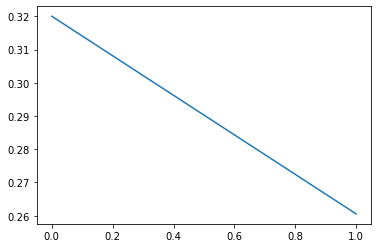

In [292]:
population_size = 4
tournament_size = 2
num_generations = 2
    
next_generation = initial_population(population_size)
bests_fitness = []
bests_genomes = []
bests_models = []
for gen in range(num_generations):
    next_generation, best_genome, best_model, best_fitness = execute_generation(next_generation, verbose=False)
    print(best_fitness)
    bests_fitness.append(best_fitness)
    bests_genomes.append(best_genome)
    bests_models.append(best_model)
    

plt.plot(bests_fitness)
    

In [306]:
def load_previous_state(layer, previous_state, i):
    bias_key = 'internal_layers.{}.conv.bias'.format(i)
    weight_key = 'internal_layers.{}.conv.weight'.format(i)
    if previous_state:
        if bias_key in previous_state:
            ps_bias = previous_state[bias_key]
            layer.conv.bias.data.copy_(ps_bias)
        if weight_key in previous_state:
            ps_weight = previous_state[weight_key].detach().clone()
            layer.conv.weight.data.copy_(ps_weight)

In [302]:
bests_fitness = np.array(bests_fitness)
best_phase_fiteness = bests_fitness[bests_fitness.argmax()] 
best_phase_genome = bests_genomes[bests_fitness.argmax()]
best_phase_model = bests_models[best_fitness.argmax()]

In [303]:
print(best_phase_genome)
print(best_phase_model)

[[16, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'tanh'], [16, 'distance', 'tree', 'elu', True, 8, 'distance', 'tree', 'leaky_relu']]
EvolutionaryNet(
  (internal_layers): ModuleList(
    (0): ST_GCN(
      (conv): Conv2d(3, 48, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (1): ST_GCN(
      (conv): Conv2d(16, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (2): ST_GCN(
      (conv): Conv2d(16, 48, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (3): ST_GCN(
      (conv): Conv2d(16, 24, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
  )
  (final_layer): Conv2d(8, 7, kernel_size=(1, 1), stride=(1, 1))
)


In [304]:
population_size = 4
next_phase_population = init_next_phase_population( best_phase_genome , population_size)
print_population(next_phase_population)


[[16, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'tanh'], [16, 'distance', 'tree', 'elu', True, 8, 'distance', 'tree', 'leaky_relu'], [4, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'elu']]
[[16, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'tanh'], [16, 'distance', 'tree', 'elu', True, 8, 'distance', 'tree', 'leaky_relu'], [16, 'group', 'tree', 'elu', True, 4, 'distance', 'tree', 'relu']]
[[16, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'tanh'], [16, 'distance', 'tree', 'elu', True, 8, 'distance', 'tree', 'leaky_relu'], [16, 'group', 'tree', 'leaky_relu', True, 8, 'distance', 'tree', 'relu']]
[[16, 'distance', 'tree', 'tanh', True, 16, 'group', 'tree', 'tanh'], [16, 'distance', 'tree', 'elu', True, 8, 'distance', 'tree', 'leaky_relu'], [8, 'distance', 'tree', 'relu', True, 16, 'distance', 'tree', 'relu']]


Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
0.5519236438679245
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando camada = 2
Carregando camada = 3
Carregando camada = 4
Carregando camada = 5
Carregando camada = 0
Carregando camada = 1
Carregando ca

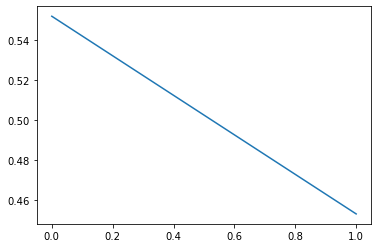

In [305]:

bests_fitness = []
bests_genomes = []
bests_models = []
next_generation = deepcopy(next_phase_population)
for gen in range(num_generations):
    next_generation, best_genome, best_model, best_fitness = execute_generation(
            next_generation,
            previous_state=best_phase_model.state_dict(),
            verbose=False)
    print(best_fitness)
    bests_fitness.append(best_fitness)
    bests_genomes.append(best_genome)
    bests_models.append(best_model)
    

plt.plot(bests_fitness)


In [328]:
population_size = 10
tournament_size = 2
num_generations = 5
num_phase = 4
    
next_generation = initial_population(population_size)
previous_state = None

overall_fitness = []
overall_genomes = []
overall_models = []

for phase in range(num_phase):
    print('Phase {}'.format(phase))
    bests_fitness = []
    bests_genomes = []
    bests_models = []
    for gen in range(num_generations):
        next_generation, best_genome, best_model, best_fitness = execute_generation(
            next_generation,
            previous_state=previous_state,
            verbose=False)
        bests_fitness.append(best_fitness)
        bests_genomes.append(best_genome)
        bests_models.append(best_model)
        print(best_fitness)
        
    bests_fitness = np.array(bests_fitness)
    best_phase_fitness = bests_fitness[bests_fitness.argmax()] 
    best_phase_genome = bests_genomes[bests_fitness.argmax()]
    best_phase_model = bests_models[bests_fitness.argmax()]
    
    overall_fitness.extend(bests_fitness)
    overall_genomes.extend(bests_genomes)
    overall_models.extend(bests_models)
    
    previous_state=best_phase_model.state_dict()
    next_phase_population = init_next_phase_population( best_phase_genome , population_size)
    next_generation = deepcopy(next_phase_population)

Phase 0
0.2845482016509434
0.29191848466981135
0.39077977594339625
0.2947155070754717
0.32211084905660375
Phase 1
0.5058888561320755
0.5508217865566036
0.5561173349056604
0.5561468160377359
0.5635465801886792
Phase 2
0.6150943396226415
0.6279591686320755
0.6500036851415094
0.6495061910377359
0.6282982016509434
Phase 3
0.6794848172169811
0.7001363502358491
0.6956736438679245
0.693801591981132
0.7009655070754717


In [325]:
EvolutionaryNet(3, 7, partition_modes, activation_functions, next_generation[0])

EvolutionaryNet(
  (internal_layers): ModuleList(
    (0): ST_GCN(
      (conv): Conv2d(3, 192, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (1): ST_GCN(
      (conv): Conv2d(32, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (2): ST_GCN(
      (conv): Conv2d(16, 6, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
  )
  (final_layer): Conv2d(2, 7, kernel_size=(1, 1), stride=(1, 1))
)

In [326]:
best_phase_model

EvolutionaryNet(
  (internal_layers): ModuleList(
    (0): ST_GCN(
      (conv): Conv2d(3, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (1): ST_GCN(
      (conv): Conv2d(32, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
  )
  (final_layer): Conv2d(16, 7, kernel_size=(1, 1), stride=(1, 1))
)

[[[32, 'group', 'tree', 'leaky_relu', True, 16, 'group', 'tree', 'tanh'],
  [2, 'distance', 'tree', 'tanh', False, 4, 'group', 'tree', 'leaky_relu']],
 [[32, 'group', 'tree', 'leaky_relu', True, 16, 'group', 'tree', 'tanh'],
  [32, 'group', 'tree', 'relu', False, 32, 'distance', 'tree', 'relu']],
 [[32, 'group', 'tree', 'leaky_relu', True, 16, 'group', 'tree', 'tanh'],
  [32, 'distance', 'tree', 'elu', False, 2, 'group', 'tree', 'leaky_relu']],
 [[32, 'group', 'tree', 'leaky_relu', True, 16, 'group', 'tree', 'tanh'],
  [2, 'distance', 'tree', 'elu', False, 8, 'group', 'tree', 'elu']]]

In [320]:
best_phase_model

EvolutionaryNet(
  (internal_layers): ModuleList(
    (0): ST_GCN(
      (conv): Conv2d(3, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
    (1): ST_GCN(
      (conv): Conv2d(32, 96, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    )
  )
  (final_layer): Conv2d(16, 7, kernel_size=(1, 1), stride=(1, 1))
)

In [322]:
best_phase_genome

[[32, 'group', 'tree', 'leaky_relu', True, 16, 'group', 'tree', 'tanh']]

In [118]:
from tqdm import tqdm
import pdb
import torch
import torch.nn as nn
from IPython.display import clear_output, display
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(action_sequences)
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
k=0
loss_history_train = []
acc_history_val = []
epoch_history = []
model_history = []
val_idx_history = []
sources = list_values_by_field_name(action_sequences, 'source')

for train_idxs, val_idxs in kf.split(action_sequences):
    
    print(train_idxs)
    print(val_idxs)
    
    train_sources = [sources[i] for i in train_idxs]
    validation_sources = [sources[i] for i in val_idxs]
    train_sequences = filter_by_metadata(augmented_action_sequences, 'source', train_sources)
    validation_sequences = filter_by_metadata(augmented_action_sequences, 'source', validation_sources)

    train_dataset = PoseSequenceDataset(train_sequences, transform=transform)
    validation_dataset = PoseSequenceDataset(validation_sequences, transform=transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    
    model = EvolutionaryNet(3, 7, partition_modes, activation_functions, genome).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    model.train()
    loss_history_train.append([])
    acc_history_val.append([])
    epoch_history.append([])
    val_idx_history.append(val_idxs)
    for epoch in range(epochs):
        print('Epoca {}'.format(epoch))

        loss_accum = 0
        for samples in train_dataloader:
            data = samples['frames'].to(device, dtype=torch.float)
            labels = samples['labels'].to(device, dtype=torch.long)

            optimizer.zero_grad()

            out = model(data)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()
            total_loss = loss.item()
            loss_accum = loss_accum + total_loss


        if (epoch + 1) % 5 == 0:
            model.eval()
            num_samples = 0
            accum = 0
            for samples in validation_dataloader:
                data = samples['frames'].to(device, dtype=torch.float)
                labels = samples['labels'].to(device, dtype=torch.long)
                out = model(data)

                accum = accum + get_accuracy(out, labels) * samples['frames'].shape[0]
                num_samples = num_samples + samples['frames'].shape[0]

            validation_accuracy = accum/num_samples

            acc_history_val[k].append(validation_accuracy)
            loss_history_train[k].append(loss_accum) 
            epoch_history[k].append(epoch)
            
            clear_output(wait=True)
            model.train()
            
            for i in range(k):
                final_loss = loss_history_train[i][-1]
                final_val_acc = acc_history_val[i][-1] 
                print('[Resultado iteração {}] - Loss: {:.4f} - Val Acc: {:.4f}'.format(i, final_loss, final_val_acc))
            

            print('[{}/{}] Loss: {:.4f} - Val Acc: {:.4f}'.format(epoch, epochs, loss_accum, validation_accuracy))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
            for i in range(k+1):
                ax1.plot(epoch_history[i], loss_history_train[i], 'b')
            ax1.grid()
            for i in range(k+1):
                ax2.plot(epoch_history[i], acc_history_val[i], 'r')
            ax2.grid()
            plt.show()
    k = k+1
    model.eval()
    model_history.append(model)

cpu
[0 2 3 4 5 6 7 9]
[1 8]
Epoca 0
Epoca 1


KeyboardInterrupt: 

In [18]:
label_colors = {
    0: matplotlib.colors.to_rgb('#c62bc6'),
    1: matplotlib.colors.to_rgb('#49bcad'),
    2: matplotlib.colors.to_rgb('#e1ff00'),
    3: matplotlib.colors.to_rgb('#00bbff'),
    4: matplotlib.colors.to_rgb('#ffd800'),
    5: matplotlib.colors.to_rgb('#00ff11'),
    6: matplotlib.colors.to_rgb('#001dff'),
    7: matplotlib.colors.to_rgb('#fff600'),
    8: matplotlib.colors.to_rgb('#d65968'),
}

In [19]:
def create_segmentation_picture(values, nodes_per_frame=16):
    flatten_values = values.flatten()
    picture = np.array([ label_colors[i] for i in flatten_values])
    picture = picture.reshape((-1,nodes_per_frame, 3))
    picture = np.transpose(picture, (1,0,2))
    return picture

In [20]:
def define_label_by_frame(values, nodes_per_frame=16):
    flatten_values = values.flatten()
    frame_wise_mode = stats.mode(flatten_values.reshape((-1, nodes_per_frame)), axis=1)
    frame_pred = frame_wise_mode[0].flatten()
    frame_pred = np.array([ [ i for j in range(16)] for i in frame_pred ])
    return frame_pred

In [21]:
def print_legend():
    fig=plt.figure(figsize=(20, 4))
    for i in idx_label.keys():
        fig.add_subplot(1, 7, i+1)
        plt.imshow(create_segmentation_picture(np.ones((16,16)) * i))
        plt.axis('off')
        plt.title(idx_label[i])
    plt.show()

{'Left Punch': 0, 'Right Punch': 1, 'Back Kick': 2, 'Right Kick': 3, 'Left Kick To The Head': 4, 'Right Kick To The Head': 5, 'Left Kick': 6}


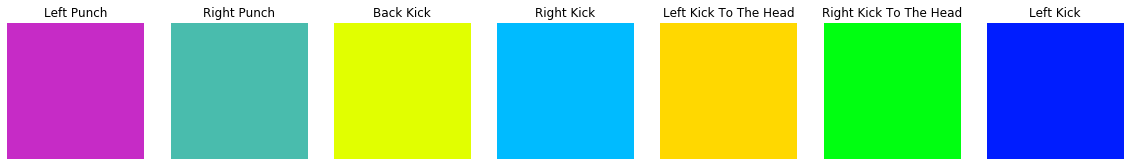

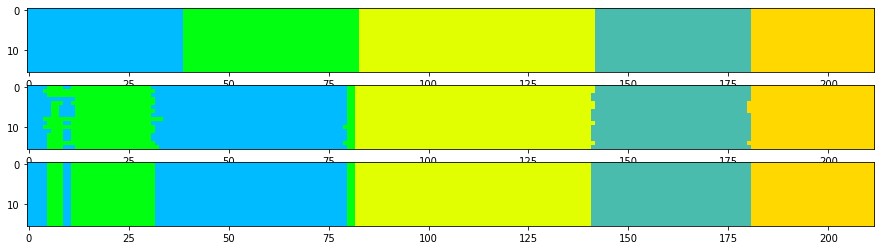

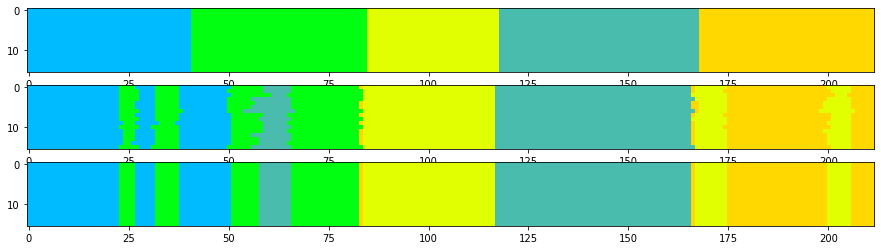

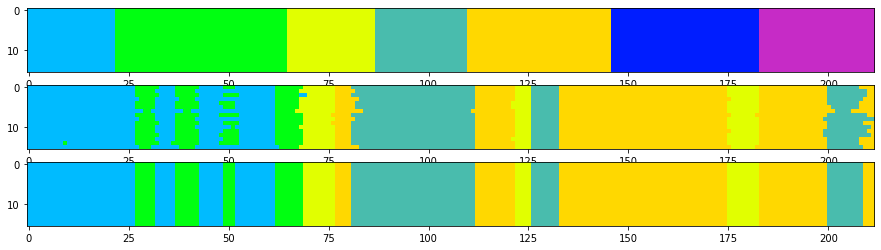

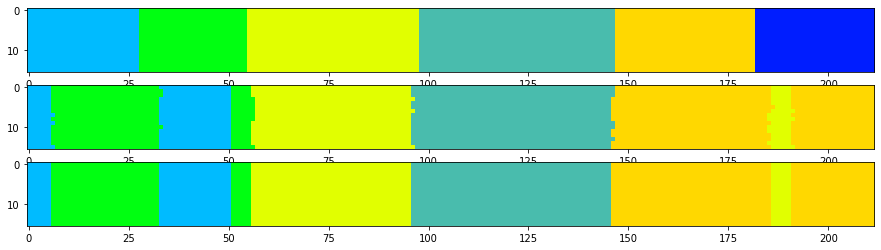

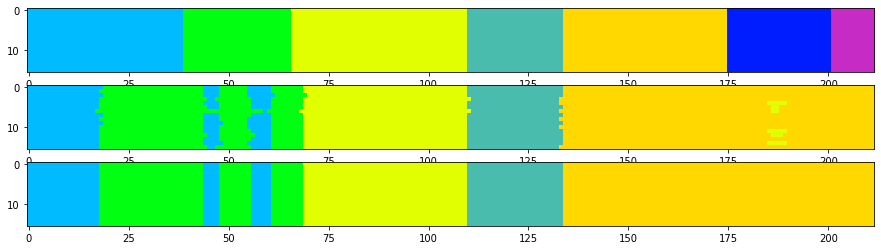

In [23]:
sample_idx = 30
print(label_idx)
print_legend()
for fold in range(len(val_idx_history)):

    validation_sources = [sources[i] for i in val_idx_history[fold]]
    validation_sequences = filter_by_metadata(augmented_action_sequences, 'source', validation_sources)
    validation_dataset = PoseSequenceDataset(validation_sequences, transform=transform)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

    for samples in validation_dataloader:
        data = samples['frames'].to(device, dtype=torch.float)
        labels = samples['labels'].to(device, dtype=torch.long)
        preds = model_history[fold](data, A)
        preds = torch.argmax(preds, dim=1)
        break;
    sample = data[sample_idx].detach().cpu().numpy();
    pred = preds[sample_idx].detach().cpu().numpy();
    label = labels[sample_idx].detach().cpu().numpy();

    labels_picture = create_segmentation_picture(label)
    preds_by_node_picture = create_segmentation_picture(pred)
    preds_by_frame_picture = create_segmentation_picture(define_label_by_frame(pred))
    
    fig=plt.figure(figsize=(20, 4))
    fig.add_subplot(3, 1, 1)
    plt.imshow(labels_picture)
    fig.add_subplot(3, 1, 2)
    plt.imshow(preds_by_node_picture)
    fig.add_subplot(3, 1, 3)
    plt.imshow(preds_by_frame_picture)

    plt.show()